## 1. Importación de librerías

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2. Función de métricas auxiliar

In [15]:
def calcular_metricas(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    mape = 100 * np.mean(np.abs((real - pred) / real))
    r2 = r2_score(real, pred)
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE', 'MAPE', 'R2'],
        'Valor': [mae, rmse, f"{smape:.2f}%", f"{mape:.2f}%", f"{r2:.2f}"]
    })
    return metricas

## 3. Carga de datos

In [ ]:
df = pd.read_csv('../output/dataset_venta.csv')
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m-%d", errors='coerce')
df = df.groupby('fecha')['monto_recibido'].sum().reset_index()
df.rename(columns={'fecha':'ds','monto_recibido':'y'}, inplace=True)

,ds,y
0,2019-01-07,5651.05
1,2019-01-08,4285.00
2,2019-01-09,15455.00
3,2019-01-10,5024.50
4,2019-01-11,6350.50


## 4. Ingeniería de características

In [31]:
df['lag_1'] = df['y'].shift(1)
df['lag_7'] = df['y'].shift(7)
df['lag_14'] = df['y'].shift(14)
df['lag_30'] = df['y'].shift(30)

df['rolling_7'] = df['y'].rolling(7).mean()
df['rolling_14'] = df['y'].rolling(14).mean()
df['rolling_30'] = df['y'].rolling(30).mean()

df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['day_of_week'] = df['ds'].dt.dayofweek

df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_dow'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_dow'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df = df.dropna()

df.head()

,ds,y,lag_1,lag_7,lag_14,lag_30,rolling_7,rolling_14,rolling_30,year,month,day,day_of_week,sin_month,cos_month,sin_dow,cos_dow
30,2019-02-11,4111.0,4383.0,3506.00,6199.0,5651.05,4075.178571,4031.767857,4264.175000,2019,2,11,0,0.866025,0.5,0.000000,1.000000
31,2019-02-12,3894.0,4111.0,5682.00,2400.0,4285.00,3819.750000,4138.482143,4251.141667,2019,2,12,1,0.866025,0.5,0.781831,0.623490
32,2019-02-13,3292.5,3894.0,4039.25,4280.5,15455.00,3713.071429,4067.910714,3845.725000,2019,2,13,2,0.866025,0.5,0.974928,-0.222521
33,2019-02-14,3421.0,3292.5,4150.00,4617.5,5024.50,3608.928571,3982.446429,3792.275000,2019,2,14,3,0.866025,0.5,0.433884,-0.900969
34,2019-02-15,1520.0,3421.0,2876.00,4896.0,6350.50,3415.214286,3741.303571,3631.258333,2019,2,15,4,0.866025,0.5,-0.433884,-0.900969


## 4. División del dataset

In [19]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

features = [
    'lag_1','lag_7','lag_14','lag_30',
    'rolling_7','rolling_14','rolling_30',
    'year','month','day','day_of_week',
    'sin_month','cos_month','sin_dow','cos_dow'
]

X_train = train[features]
y_train = train['y']
X_test = test[features]
y_test = test['y']

## 5. Entrenamiento y predicción del modelo

In [21]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=3,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [22]:
metricas_rf = calcular_metricas(y_test, pred)
print(metricas_rf)

  Métrica       Valor
0     MAE  488.886451
1    RMSE  649.234646
2   sMAPE      28.27%
3    MAPE      35.70%
4      R2        0.29


## 6. Gráficos

In [ ]:
line_real = dict(color='#000000', linewidth=1.2, label='Datos reales')
line_pred = dict(color='#1f77b4', linewidth=1.2, linestyle='--', label='Predicción')
grid_opts = dict(linestyle='--', alpha=0.25)

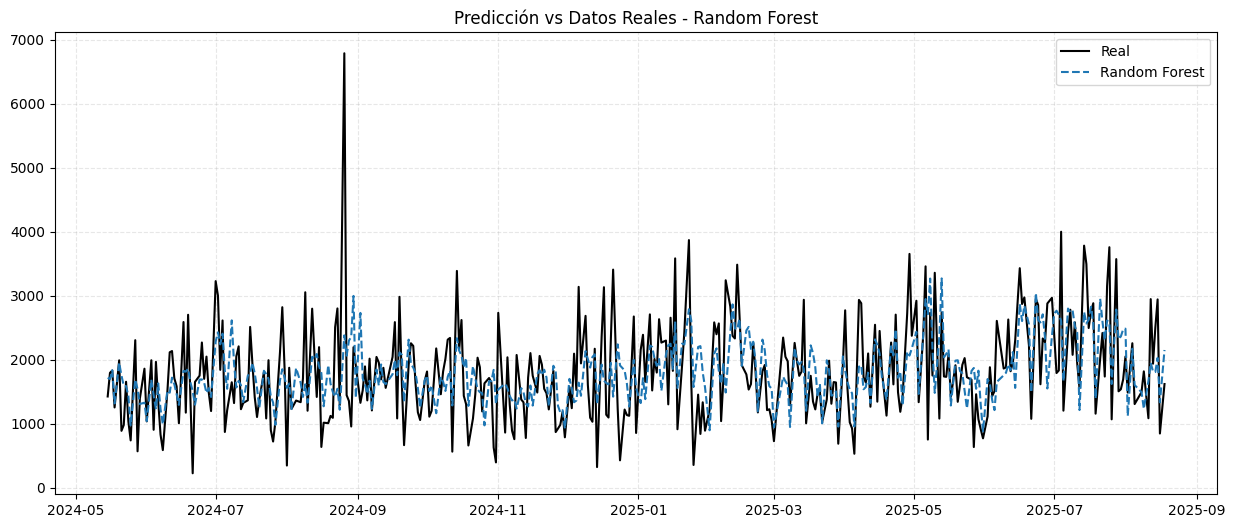

In [23]:
plt.figure(figsize=(15,6))
plt.plot(test['ds'], y_test, label='Real', color='black')
plt.plot(test['ds'], pred, label='Random Forest', linestyle='--', color='tab:blue')
plt.title("Predicción vs Datos Reales - Random Forest")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

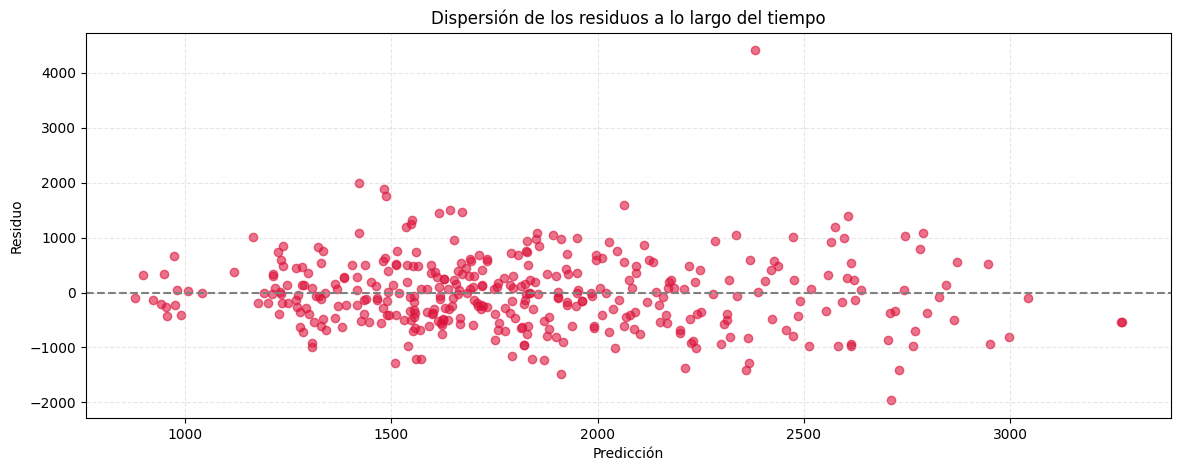

In [34]:
residuos = y_test.values - pred

plt.figure(figsize=(14,5))
plt.scatter(pred, residuos, alpha=0.6, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Dispersión de los residuos a lo largo del tiempo")
plt.xlabel("Predicción")
plt.ylabel("Residuo")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

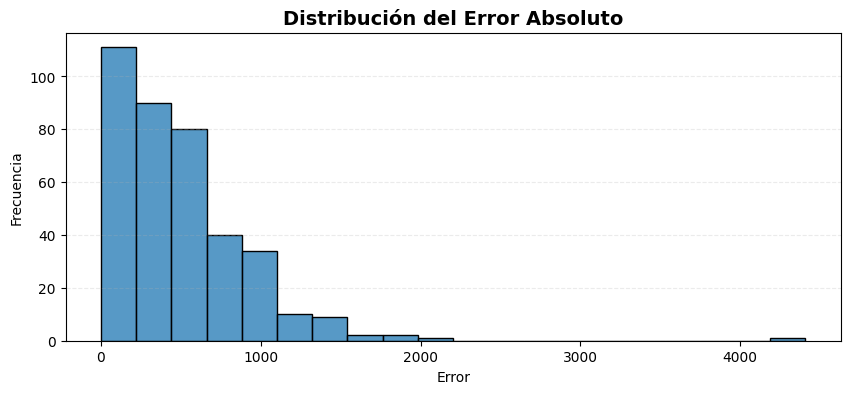

In [35]:
plt.figure(figsize=(10,4))
sns.histplot(abs(residuos), bins=20, edgecolor='black')
plt.title('Distribución del Error Absoluto', fontsize=14, weight='bold')
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

In [28]:
resultado_rf = pd.DataFrame({
    'ds': test['ds'].values,
    'real': y_test.values,
    'prediccion': pred,
    'residuo': residuos
})
resultado_rf.tail(10)

,ds,real,prediccion,residuo
370,2025-08-05,1306.50,1603.512747,-297.012747
371,2025-08-08,1493.00,1492.381904,0.618096
372,2025-08-09,1817.50,1232.870915,584.629085
373,2025-08-11,1085.00,1666.339278,-581.339278
374,2025-08-12,2946.75,1949.810970,996.939030
375,2025-08-13,1937.00,1813.964344,123.035656
376,2025-08-14,2498.00,1807.166979,690.833021
377,2025-08-15,2942.00,2028.179055,913.820945
378,2025-08-16,846.50,1334.017651,-487.517651
379,2025-08-18,1619.50,2151.480061,-531.980061


In [29]:
resultado_rf.to_csv(f'../output/prediccion_random_forest.csv', index=False)
print(f"✅ Archivo exportado: prediccion_random_forest.csv")


✅ Archivo exportado: prediccion_random_forest.csv
